<a href="https://colab.research.google.com/github/shainagrover05/Twitter-Financial-News-Sentiment-Analysis/blob/main/Twitter_Financial_News_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Twitter Financial News dataset (an English-language dataset containing an annotated corpus of finance-related
tweets),
Tweets are classified as bullish, bearish, or neutral based on sentiment.

In [105]:
from datasets import load_dataset
import pandas as pd

splits = {'train': 'sent_train.csv', 'validation': 'sent_valid.csv'}
train_test_df = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["train"])
validation_df = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["validation"])


# removing duplicates within the two datasets we retrieved
train_test_df = train_test_df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)
validation_df = validation_df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)

Since we just retrieved from HuggingFace, need to check for data leaks between
both datasets given to us

In [106]:
train_pairs = set(zip(train_test_df["text"], train_test_df["label"]))
valid_pairs = set(zip(validation_df["text"], validation_df["label"]))
len_overlap = len(train_pairs & valid_pairs)
print("Number of overlapping between train and validation:", len_overlap)

Number of overlapping between train and validation: 0


In [107]:
#Also checking for NA fields
train_test_df.isna().sum()

,0
text,0
label,0


In [108]:
validation_df.isna().sum()

,0
text,0
label,0


We will also ensure that the splits given from huggging face are somewhat stratified

In [109]:
def label_dist(df):
  return df["label"].value_counts(normalize=True).sort_index()

print("Overall label distribution (train+validation):")
all_df = pd.concat([train_test_df, validation_df], ignore_index=True)
print(label_dist(all_df), "\n")

print("HF train distribution:")
print(label_dist(train_test_df), "\n")

print("HF validation distribution:")
print(label_dist(validation_df))

Overall label distribution (train+validation):
label
0    0.149946
1    0.200989
2    0.649065
Name: proportion, dtype: float64 

HF train distribution:
label
0    0.151106
1    0.201509
2    0.647386
Name: proportion, dtype: float64 

HF validation distribution:
label
0    0.145310
1    0.198911
2    0.655779
Name: proportion, dtype: float64


In [110]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_test_df, stratify=train_test_df["label"], test_size=0.15, random_state=42)
valid = validation_df

train.head()

,text,label
2492,"$BL - BlackLine, Inc. 2019 Q3 - Results - Earn...",2
3813,"A 16,700% return in 50 years makes Hong Kong's...",1
3557,"$ELVT - Elevate Credit EPS beats by $0.03, mis...",2
1963,T-Mobile CEO: 'Was never having discussions' t...,2
5032,Riassunto: Kioxia sviluppa la nuova struttura ...,2


2. Explain the main features in the data that you are studying and why:

We are studying the relation between the feature (tweets, represented by the column "text") and the label (sentiment, represented
by the column "label").

We are doing this to determine how the words in the tweet can affect the financial sentiment (bullish, bearish, or neutral), which
could be used by financial companies to assess market trends.

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8111 entries, 2492 to 9239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8111 non-null   object
 1   label   8111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 190.1+ KB


In [112]:
train.shape

(8111, 2)

In [113]:
print("Train:")
print(label_dist(train), "\n")

print("Test:")
print(label_dist(test), "\n")

print("Valid:")
print(label_dist(valid))

Train:
label
0    0.151153
1    0.201455
2    0.647392
Name: proportion, dtype: float64 

Test:
label
0    0.150838
1    0.201816
2    0.647346
Name: proportion, dtype: float64 

Valid:
label
0    0.145310
1    0.198911
2    0.655779
Name: proportion, dtype: float64


3. Data Cleaning:
Since we already tested for NA fields and duplicates earlier and saw that there were none, we are now cleaning the text data
For texts, we are cleaning three things(respectively):


* removing URLs
* removing twitter tags(@)
* stripping any whitespace





In [114]:
#Here we need to use regex to properly standardize the text
import re

def clean_text(text):
  text = str(text)
  text = re.sub(r"http\S+|www\S+",
  "", text)
  text = re.sub(r"@\w+",
  "", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [115]:
for name, df_split in [("train", train), ("valid", valid), ("test", test)]:
  df_split["clean_text"] = df_split["text"].apply(clean_text)
  df_split["char_len"] = df_split["clean_text"].str.len()
  df_split["word_len"] = df_split["clean_text"].str.split().str.len()
  print(name, df_split.shape)

train (8111, 5)
valid (2388, 5)
test (1432, 5)


We are calculating weights below to account for class imbalance when actually training and testing

In [116]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1, 2])

weights = compute_class_weight(
  class_weight="balanced",
  classes=classes,
  y=train["label"]
)

weights

array([2.20527461, 1.65463076, 0.51488605])

For EDA, we will be seeing what words are most common in each class

In [117]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


def top_words(df, label, n=20):
  subset = df[df["label"] == label]["clean_text"]
  vec = CountVectorizer(stop_words="english").fit(subset)
  bag = vec.transform(subset)
  sums = bag.sum(axis=0).A1
  words = vec.get_feature_names_out()
  top_idx = sums.argsort()[::-1][:n]
  return words[top_idx], sums[top_idx]


def plot_top_words(df, label, label_name, n=15):
  words, counts = top_words(df, label, n)

  plt.figure(figsize=(10, 6))
  plt.barh(words[::-1], counts[::-1], color="steelblue")
  plt.title(f"Top {n} Words for {label_name} Tweets")
  plt.xlabel("Frequency")
  plt.ylabel("Word")
  plt.tight_layout()
  plt.show()

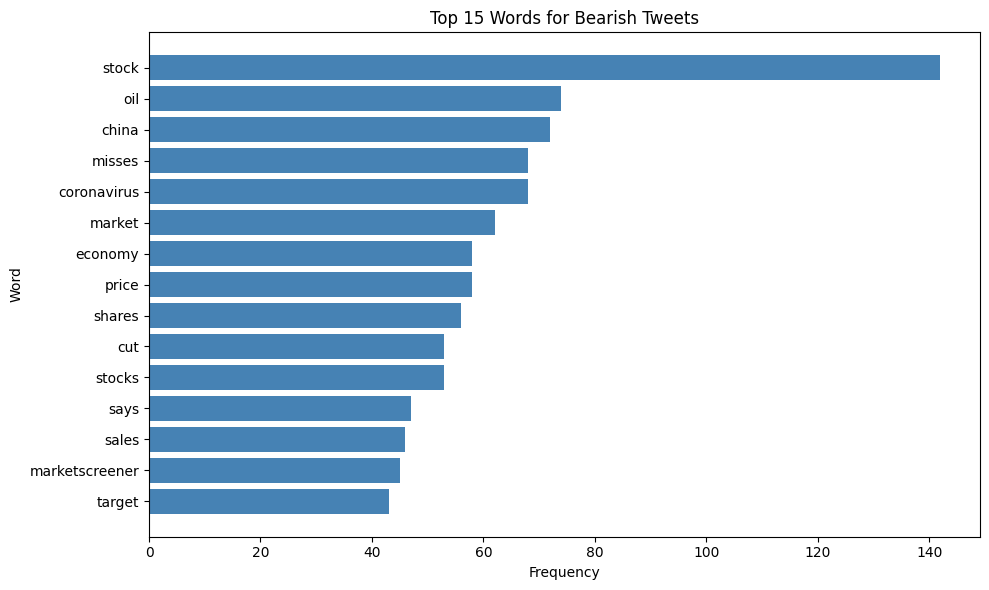

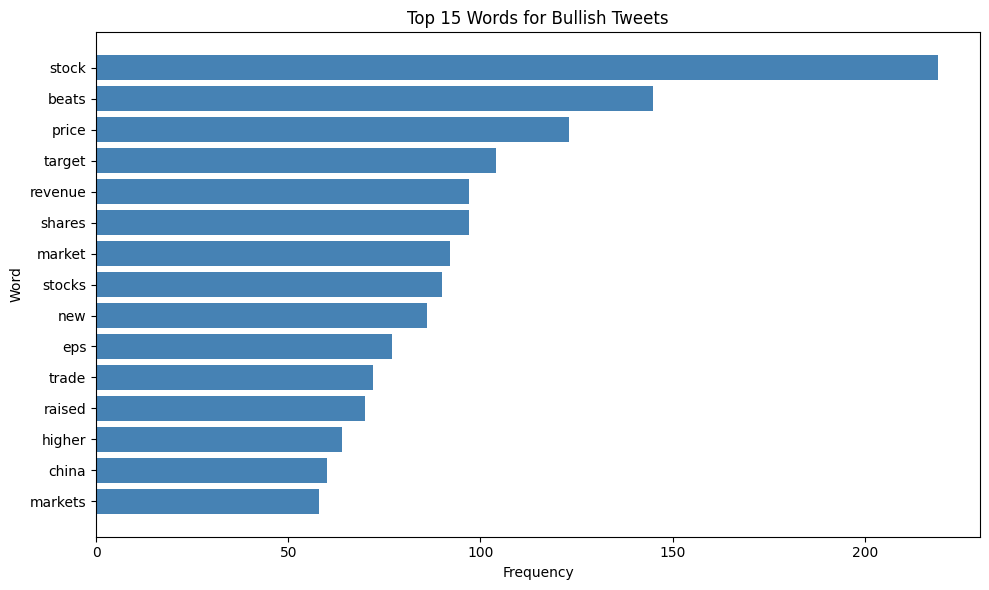

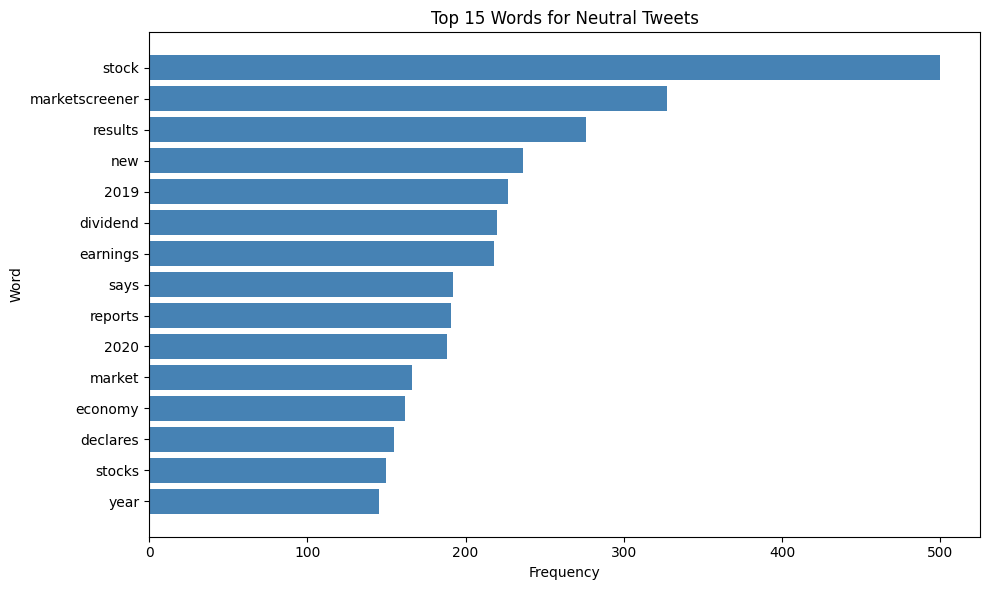

In [118]:
plot_top_words(train, 0, "Bearish")
plot_top_words(train, 1, "Bullish")
plot_top_words(train, 2, "Neutral")

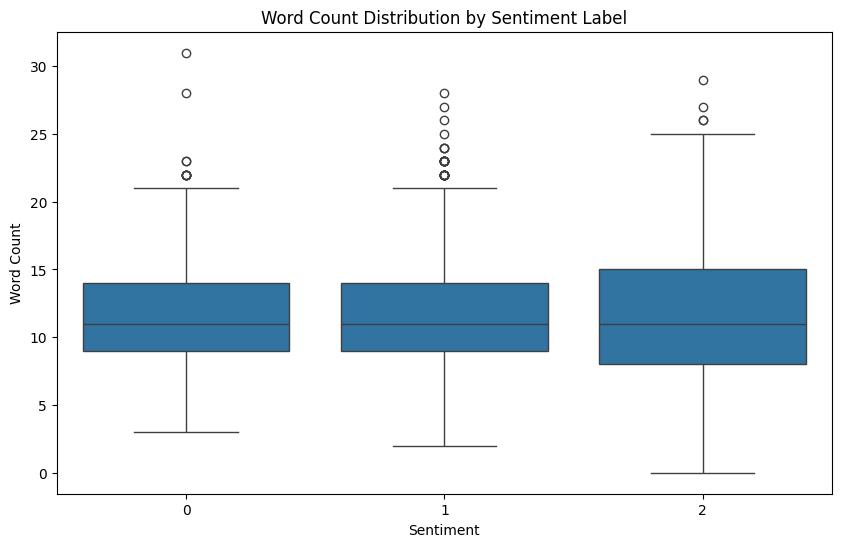

In [119]:
import seaborn as sns


plt.figure(figsize=(10,6))
sns.boxplot(data=train, x="label", y="word_len")
plt.title("Word Count Distribution by Sentiment Label")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

Observations:

* One key observation is the repeat of words like "stock" or "new", but if we were to use something like TF-IDF, we can account for not weighing recurring words too much.
* However, we also do see very useful words showing up in the top 10, like "beats" in Bullish and "misses" in Bearish, which have opposite tones
* We also notice that they all have pretty similar lengths for the most part, regardless of sentiment



Linear Regression:

* This data having classes for each text makes it an obvious classification problem, so we can use linear regression to learn if there is underlaying relationships
* We were considering using TF-IDF or embeddings at this point to get more features
* The problem with this is that TF-IDF generates lots and lots of features so it is in bound to overfit without a large amount of regularization
* Embeddings become uninterpretable, so we cannot learn anything from running regression on this data

In [120]:
# Note: char_len and word_len were already calculated on clean_text in Cell 17
# These features are being recalculated here for the linear regression model
# Using clean_text for consistency with the rest of the pipeline

train["char_len"] = train["clean_text"].str.len()
train["word_len"] = train["clean_text"].str.split().apply(len)
test["char_len"] = test["clean_text"].str.len()
test["word_len"] = test["clean_text"].str.split().apply(len)
valid["char_len"] = valid["clean_text"].str.len()
valid["word_len"] = valid["clean_text"].str.split().apply(len)

def count_tickers(text):
  if not isinstance(text, str):
    return 0
  return sum(1 for word in text.split() if word.startswith("$"))

# Using clean_text for consistency (tickers with $ should still be preserved after cleaning)
train["num_tickers"] = train["clean_text"].apply(count_tickers)
test["num_tickers"] = test["clean_text"].apply(count_tickers)
valid["num_tickers"] = valid["clean_text"].apply(count_tickers)

In [121]:
def avg_word_length(text):
  if not isinstance(text, str):
    return 0
  words = text.split()
  if len(words) == 0:
    return 0
  return sum(len(w) for w in words) / len(words)

# Using clean_text for consistency
train["avg_word_length"] = train["clean_text"].apply(avg_word_length)
test["avg_word_length"] = test["clean_text"].apply(avg_word_length)
valid["avg_word_length"] = valid["clean_text"].apply(avg_word_length)

In [122]:
def count_numbers(text):
  if not isinstance(text, str):
    return 0
  return len(re.findall(r"\d", text))

# Using clean_text for consistency
train["num_numbers"] = train["clean_text"].apply(count_numbers)
test["num_numbers"] = test["clean_text"].apply(count_numbers)
valid["num_numbers"] = valid["clean_text"].apply(count_numbers)

In [123]:
train.columns

Index(['text', 'label', 'clean_text', 'char_len', 'word_len', 'num_tickers',
       'avg_word_length', 'num_numbers'],
      dtype='object')

In [124]:
from sklearn.linear_model import LinearRegression

X = train[["char_len", "word_len", "num_tickers", "num_numbers", "avg_word_length"]]
y = train["label"]

reg = LinearRegression()
reg.fit(X, y)

reg.coef_, reg.intercept_

(array([ 0.00256227, -0.00597115, -0.03917112, -0.01126521,  0.0502149 ]),
 np.float64(1.136086450409397))

Analysis:

* Since we are using the linear regression to see feature importance for out features we just engineered above, we did not test this line on the validation set
* The magnitude of the coefficients tells us about the feature importance
* We do not need a regularization here as we have low-dimensionality, so it would not usually overfit

Logistic Regression

Currently, the data classifies the tweets as bullish, bearish, or neutral. For this section, we will be choosing the binary categorical data to
be "bullish" and bearish

In [125]:
train_binary = train[train["label"].isin([0, 1])].copy()
train_binary["y_binary"] = (train_binary["label"] == 1).astype("int64")
valid_binary = valid[valid["label"].isin([0, 1])].copy()
valid_binary["y_binary"] = (valid_binary["label"] == 1).astype("int64")
test_binary = test[test["label"].isin([0, 1])].copy()
test_binary["y_binary"] = (test_binary["label"] == 1).astype("int64")
train_binary["y_binary"].value_counts()

,count
y_binary,
1,1634
0,1226


We are using TF-IDF for our predictor. TF-IDF is only on the training text to prevent data leakage. Validation text is going to be transformed
by using the training-fitted vectorizer

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_text = train_binary["clean_text"]
y_train_bin = train_binary["y_binary"]
X_valid_text = valid_binary["clean_text"]
y_valid_bin = valid_binary["y_binary"]
X_test_text = test_binary["clean_text"]
y_test_bin = test_binary["y_binary"]

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_valid_tfidf = tfidf.transform(X_valid_text)
X_test_tfidf = tfidf.transform(X_test_text)
print(X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape)

(2860, 5000) (822, 5000) (505, 5000)


In [127]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train_bin)

LogisticRegression(max_iter=2000)

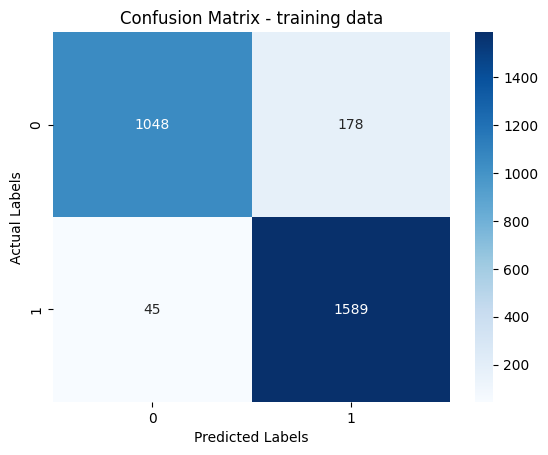

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1226
           1       0.90      0.97      0.93      1634

    accuracy                           0.92      2860
   macro avg       0.93      0.91      0.92      2860
weighted avg       0.92      0.92      0.92      2860



In [128]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train_tfidf)
cm_train = confusion_matrix(y_train_bin, y_pred_train)
accuracy_train = accuracy_score(y_train_bin, y_pred_train)
TN, FP, FN, TP = cm_train.ravel()

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - training data")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

print("Classification Report:")
print(classification_report(y_train_bin, y_pred_train))

In [129]:
#explicit calculations of true positive and negative rates - TRAINING DATA

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)
print("Accuracy: ", accuracy_train)
print("Prediction Error: ", 1 - accuracy_train)

True Positive Rate (TPR): 0.9724602203182374
True Negative Rate (TNR): 0.8548123980424144
Accuracy:  0.922027972027972
Prediction Error:  0.07797202797202796


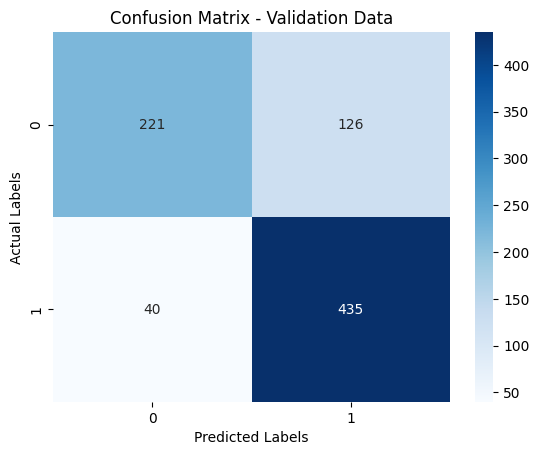

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       347
           1       0.78      0.92      0.84       475

    accuracy                           0.80       822
   macro avg       0.81      0.78      0.78       822
weighted avg       0.81      0.80      0.79       822



In [130]:
y_pred = model.predict(X_valid_tfidf)
cm = confusion_matrix(y_valid_bin, y_pred)
accuracy = accuracy_score(y_valid_bin, y_pred)
TN, FP, FN, TP = cm.ravel()

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Validation Data")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

print("Classification Report:")
print(classification_report(y_valid_bin, y_pred))

In [131]:
#explicit calculations of true positive and negative rates - VALIDATION DATA
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)
print("Accuracy: ", accuracy)
print("Prediction Error: ", 1 - accuracy)

True Positive Rate (TPR): 0.9157894736842105
True Negative Rate (TNR): 0.6368876080691642
Accuracy:  0.7980535279805353
Prediction Error:  0.2019464720194647


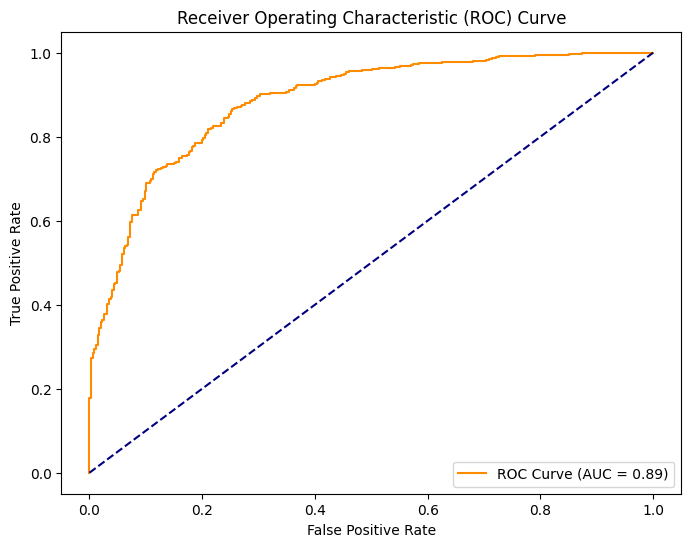

In [132]:
#ROC Curve

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_valid_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid_bin, y_prob)
roc_auc = roc_auc_score(y_valid_bin, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [133]:
#5 fold stratified cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
('tfidf', TfidfVectorizer(stop_words="english", max_features=5000)),
('model', LogisticRegression(max_iter=2000))
])

cv_scores = cross_validate(pipeline, valid_binary["clean_text"], valid_binary["y_binary"], cv=5, scoring=["accuracy", "roc_auc"])
print("Cross-validation scores:")
print("Fold Accuracies: ", cv_scores["test_accuracy"])
print("Fold AUCs: ", cv_scores["test_roc_auc"])
print("Mean Accuracy: ", np.mean(cv_scores["test_accuracy"]))
print("Mean AUC: ", np.mean(cv_scores["test_roc_auc"]))


for i in range(len(cv_scores["test_accuracy"])):
  print(f"Fold {i+1}: Accuracy = {cv_scores['test_accuracy'][i]:.3f}, AUC = {cv_scores['test_roc_auc'][i]:.3f}")

Cross-validation scores:
Fold Accuracies:  [0.64242424 0.63030303 0.59756098 0.61585366 0.6402439 ]
Fold AUCs:  [0.78225564 0.69413534 0.65369947 0.64851259 0.70144928]
Mean Accuracy:  0.6252771618625277
Mean AUC:  0.6960104609349461
Fold 1: Accuracy = 0.642, AUC = 0.782
Fold 2: Accuracy = 0.630, AUC = 0.694
Fold 3: Accuracy = 0.598, AUC = 0.654
Fold 4: Accuracy = 0.616, AUC = 0.649
Fold 5: Accuracy = 0.640, AUC = 0.701


Calculating threshold for positive predictions using Youden's J - maximum vertical distance between ROC curve and diagonal line.

In [134]:
J = tpr - fpr
ix = np.argmax(J)
new_threshold = thresholds[ix]
print("Best threshold (using Youden's J)", new_threshold)
print("TPR at best threshold", tpr[ix])
print("FPR at best threshold", fpr[ix])

Best threshold (using Youden's J) 0.5377560625332966
TPR at best threshold 0.8694736842105263
FPR at best threshold 0.2564841498559078


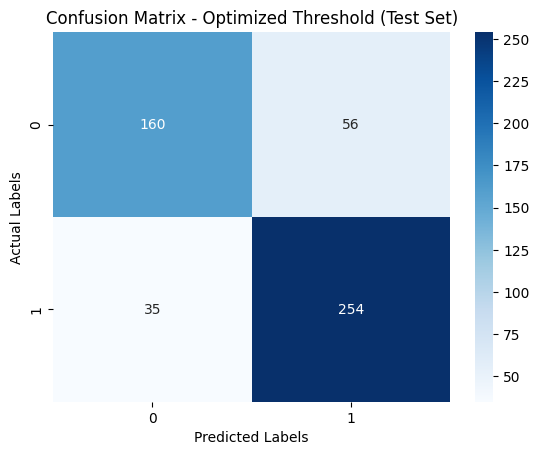

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       216
           1       0.82      0.88      0.85       289

    accuracy                           0.82       505
   macro avg       0.82      0.81      0.81       505
weighted avg       0.82      0.82      0.82       505

True Positive Rate (TPR with optimized threshold): 0.8788927335640139
True Negative Rate (TNR with optimized threshold): 0.7407407407407407
Accuracy (optimized threshold):  0.8198019801980198
Prediction Error (optimized threshold):  0.18019801980198025


In [135]:
#new predictions
y_prob_test = model.predict_proba(X_test_tfidf)[:,1]
y_pred_test = (y_prob_test >= new_threshold).astype(int)

#new confusion matrix and metrics - test data
cm_test = confusion_matrix(y_test_bin, y_pred_test)
accuracy_test = accuracy_score(y_test_bin, y_pred_test)
TN, FP, FN, TP = cm_test.ravel()

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Optimized Threshold (Test Set)")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

print("Classification Report:")
print(classification_report(y_test_bin, y_pred_test))

#explicit calculations
TPR_test = TP / (TP + FN)
TNR_test = TN / (TN + FP)
print("True Positive Rate (TPR with optimized threshold):", TPR_test)
print("True Negative Rate (TNR with optimized threshold):", TNR_test)
print("Accuracy (optimized threshold): ", accuracy_test)
print("Prediction Error (optimized threshold): ", 1 - accuracy_test)

In [136]:
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_.ravel()
coef_df = pd.DataFrame({"word": feature_names, "coefficient": coefs})
top_bullish = coef_df.sort_values("coefficient", ascending = False).head(10)
top_bearish = coef_df.sort_values("coefficient", ascending = True).head(10)
print("top bullish:")
display(top_bullish)
print("top bearish:")
display(top_bearish)

top bullish:


,word,coefficient
376,beats,3.499174
3915,raised,3.173202
2223,higher,2.598493
606,bullish,2.596292
4169,rises,2.224523
3705,positive,2.045161
2222,high,1.969751
623,buy,1.901987
4829,upgraded,1.874737
2608,jump,1.773117


top bearish:


,word,coefficient
3061,misses,-3.451717
1424,downgraded,-3.100060
2855,lower,-2.824179
1139,cut,-2.631103
1735,falls,-2.465508
2843,loss,-1.777125
3335,offering,-1.708808
1033,coronavirus,-1.609634
1731,fall,-1.584729
2883,macy,-1.572304


Random Forest Classification

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score)

X_train_rf_text = train_binary["clean_text"]
y_train_rf = train_binary["y_binary"]
X_valid_rf_text = valid_binary["clean_text"]
y_valid_rf = valid_binary["y_binary"]

rf_pipeline = Pipeline([("tfidf", TfidfVectorizer(stop_words = "english", max_features = 5000)), ("rf", RandomForestClassifier())])
rf_pipeline.fit(X_train_rf_text, y_train_rf)

rfTrainPred = rf_pipeline.predict(X_train_rf_text)

#confusion matrix
cmRf = confusion_matrix(y_train_rf, rfTrainPred)
TN, FP, FN, TP = cmRf.ravel()

In [138]:
#Metrics (training)
rf_accuracy = accuracy_score(y_train_rf, rfTrainPred)
rf_tpr = TP / (TP + FN)
rf_tnr = TN / (TN + FP)
rf_f1 = f1_score(y_train_rf, rfTrainPred)
rf_error = 1 - rf_accuracy

print("Random Forest Metrics (Training Data):")
print("Confusion Matrix: " + str(cmRf))
print("Accuracy: " + str(rf_accuracy))
print("TPR: " + str(rf_tpr))
print("TNR: " + str(rf_tnr))
print("F1 Score: " + str(rf_f1))
print("Prediction Error: " + str(rf_error))

Random Forest Metrics (Training Data):
Confusion Matrix: [[1222    4]
 [   1 1633]]
Accuracy: 0.9982517482517482
TPR: 0.9993880048959608
TNR: 0.9967373572593801
F1 Score: 0.9984714154692754
Prediction Error: 0.0017482517482517723


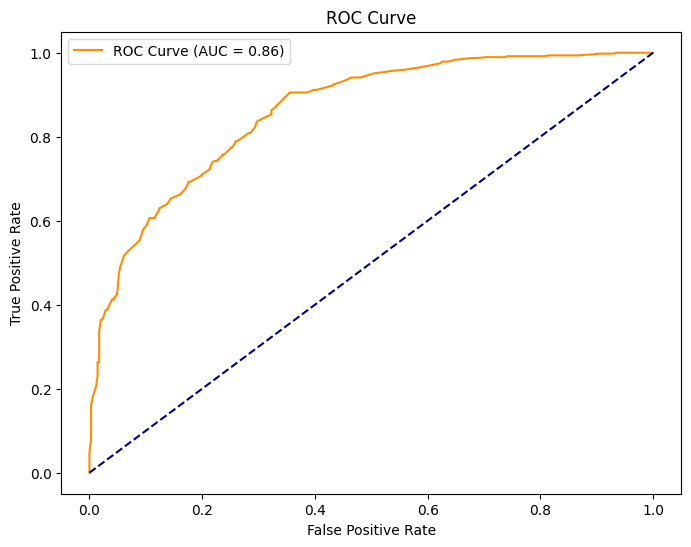

Validation AUC: 0.8593113908691036


In [139]:
rfValidProb = rf_pipeline.predict_proba(X_valid_rf_text)[:, 1]
fprRf, tprRf, _ = roc_curve(y_valid_rf, rfValidProb)
aucRf = roc_auc_score(y_valid_rf, rfValidProb)

plt.figure(figsize=(8, 6))
plt.plot(fprRf, tprRf, label=f'ROC Curve (AUC = {aucRf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("Validation AUC: " + str(aucRf))

In [140]:
#5-fold Cross-Validation set
stratFold = cross_validate(rf_pipeline, valid_binary["clean_text"], valid_binary["y_binary"], cv=5, scoring=["accuracy", "roc_auc"])

print("Cross-validation scores:")
print("Fold Accuracies: " + str(stratFold["test_accuracy"]))
print("Fold AUCs: " + str(stratFold["test_roc_auc"]))
print("Mean Accuracy: " + str(np.mean(stratFold["test_accuracy"])))
print("Mean AUC: " + str(np.mean(stratFold["test_roc_auc"])))

for i in range(len(stratFold["test_accuracy"])):
  print(f"Fold {i+1}: Accuracy = {stratFold['test_accuracy'][i]:.3f}, AUC = {stratFold['test_roc_auc'][i]:.3f}")

Cross-validation scores:
Fold Accuracies: [0.62424242 0.58787879 0.51219512 0.58536585 0.61585366]
Fold AUCs: [0.66578947 0.60120301 0.51662853 0.59664378 0.60350877]
Mean Accuracy: 0.5851071692535107
Mean AUC: 0.5967547128691294
Fold 1: Accuracy = 0.624, AUC = 0.666
Fold 2: Accuracy = 0.588, AUC = 0.601
Fold 3: Accuracy = 0.512, AUC = 0.517
Fold 4: Accuracy = 0.585, AUC = 0.597
Fold 5: Accuracy = 0.616, AUC = 0.604


PCA (Principal Component Analysis) and K-means Clustering

We will apply PCA to reduce the dimensionality of our TF-IDF features and then perform K-means clustering to see if we can discover
natural groupings in the data that correspond to sentiment labels.

In [141]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

def fit_svd(X_train, X_valid, n_components, random_state=42):
  # Using TruncatedSVD for efficiency
  max_allowed = min(X_train.shape[0] - 1, X_train.shape[1] - 1)
  n_use = min(n_components, max_allowed)
  svd = TruncatedSVD(n_components=n_use, random_state=random_state)
  X_train_red = svd.fit_transform(X_train)
  X_valid_red = svd.transform(X_valid)
  return svd, X_train_red, X_valid_red, n_use

n_components = 100
svd, X_train_pca, X_valid_pca, n_used = fit_svd(X_train_tfidf, X_valid_tfidf, n_components)

print(f"Original TF-IDF shape: {X_train_tfidf.shape}")
print(f"SVD-reduced shape: {X_train_pca.shape}")
print(f"\nExplained variance ratio (first 10 components): {svd.explained_variance_ratio_[:10]}")
print(f"Total explained variance (first {n_used} components): {svd.explained_variance_ratio_.sum():.4f}")

Original TF-IDF shape: (2860, 5000)
SVD-reduced shape: (2860, 100)

Explained variance ratio (first 10 components): [0.0106104  0.0073919  0.00603869 0.00695687 0.00525345 0.00527743
 0.00467292 0.0048096  0.00404938 0.0038035 ]
Total explained variance (first 100 components): 0.2414


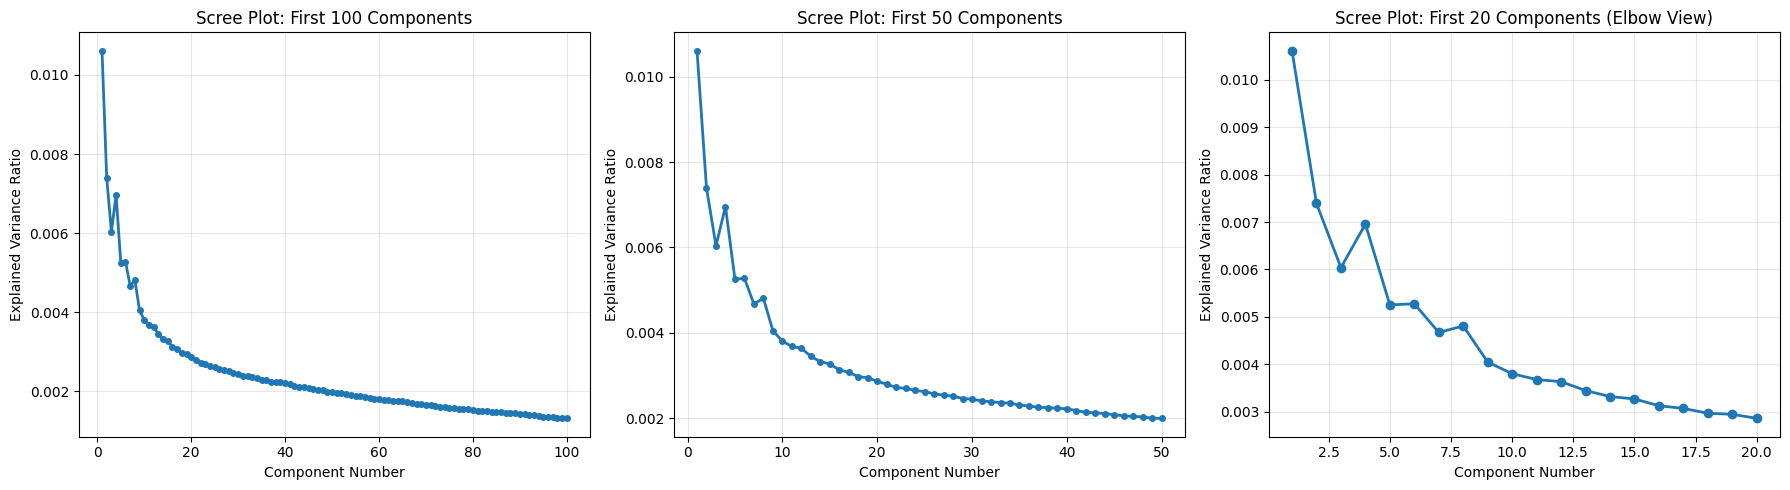

In [142]:
import matplotlib.pyplot as plt
import numpy as np
var = svd.explained_variance_ratio_
cum = np.cumsum(var)
n_avail = len(var)

#scree plots
plt.figure(figsize=(18, 5))

# First 100 components
plt.subplot(1, 3, 1)
n100 = min(100, n_avail)
plt.plot(range(1, n100 + 1), var[:n100], 'o-', linewidth=2, markersize=4)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Scree Plot: First {n100} Components')
plt.grid(True, alpha=0.3)

# First 50 components
plt.subplot(1, 3, 2)
n50 = min(50, n_avail)
plt.plot(range(1, n50 + 1), var[:n50], 'o-', linewidth=2, markersize=4)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Scree Plot: First {n50} Components')
plt.grid(True, alpha=0.3)

#First 20 components
plt.subplot(1, 3, 3)
n20 = min(20, n_avail)
plt.plot(range(1, n20 + 1), var[:n20], 'o-', linewidth=2, markersize=6)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Scree Plot: First {n20} Components (Elbow View)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [143]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def hungarian_map_clusters_to_labels(clusters, true_labels):
  """
  Hungarian mapping for binary (2-class) setting.
  """
  clusters = np.asarray(clusters)
  true_labels = np.asarray(true_labels)

  cluster_ids = np.unique(clusters)
  class_ids = np.unique(true_labels)

  confusion = np.zeros((len(cluster_ids), len(class_ids)), dtype=int)
  for i, c in enumerate(cluster_ids):
    for j, y in enumerate(class_ids):
      confusion[i, j] = np.sum((clusters == c) & (true_labels == y))
  row_ind, col_ind = linear_sum_assignment(-confusion)
  mapping = {cluster_ids[r]: class_ids[c] for r, c in zip(row_ind, col_ind)}

  mapped_labels = np.array([mapping[int(c)] for c in clusters])
  return mapped_labels, confusion, mapping

n_clusters = 2

In [144]:
from sklearn.metrics import silhouette_score
import numpy as np

y_train = train_binary["y_binary"].astype(int)
y_valid = valid_binary["y_binary"].astype(int)

n_components_pca = 100
svd_pca, X_train_pca_reduced, X_valid_pca_reduced, n_used_pca = fit_svd(
  X_train_tfidf, X_valid_tfidf, n_components_pca
)

kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
train_clusters_pca = kmeans_pca.fit_predict(X_train_pca_reduced)
valid_clusters_pca = kmeans_pca.predict(X_valid_pca_reduced)

silhouette_train = silhouette_score(X_train_pca_reduced, train_clusters_pca)

print(f"\nK-means clustering ({n_clusters} clusters)")
print(f"Training cluster distribution: {np.bincount(train_clusters_pca)}")
print(f"Validation cluster distribution: {np.bincount(valid_clusters_pca)}")
print(f"Silhouette (train): {silhouette_train:.4f}")
print(f"Inertia (train): {kmeans_pca.inertia_:.2f}")



K-means clustering (2 clusters)
Training cluster distribution: [ 106 2754]
Validation cluster distribution: [ 33 789]
Silhouette (train): 0.2270
Inertia (train): 657.18


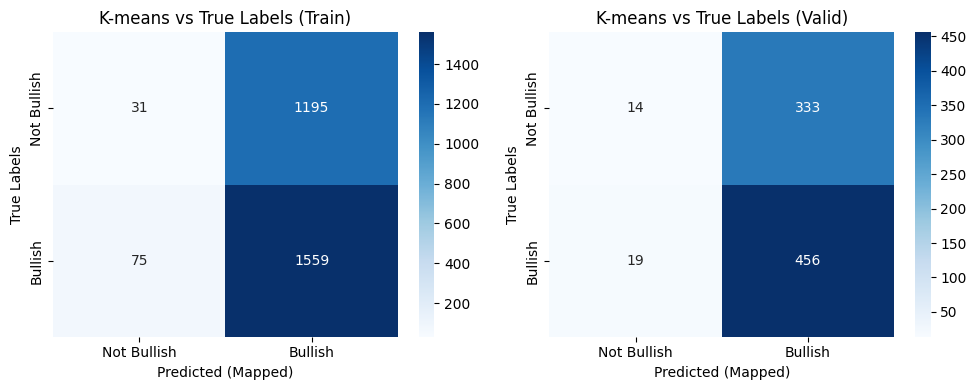

Cluster → Label mapping: {np.int32(0): np.int64(0), np.int32(1): np.int64(1)}
Train Accuracy: 0.5559
Valid Accuracy: 0.5718


In [145]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


labels_order = [0, 1]
tick_names = ["Not Bullish", "Bullish"]

train_mapped_pca, cm_train_pca, mapping_pca = hungarian_map_clusters_to_labels(
  train_clusters_pca, y_train.values
)

valid_mapped_pca = np.array([mapping_pca[int(c)] for c in valid_clusters_pca])

cm_kmeans_train_pca = confusion_matrix(y_train, train_mapped_pca, labels=labels_order)
cm_kmeans_valid_pca = confusion_matrix(y_valid, valid_mapped_pca, labels=labels_order)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_kmeans_train_pca, annot=True, fmt="d", cmap="Blues", xticklabels=tick_names, yticklabels=tick_names)
plt.title("K-means vs True Labels (Train)")
plt.ylabel("True Labels")
plt.xlabel("Predicted (Mapped)")

plt.subplot(1, 2, 2)
sns.heatmap(cm_kmeans_valid_pca, annot=True, fmt="d", cmap="Blues", xticklabels=tick_names, yticklabels=tick_names)
plt.title("K-means vs True Labels (Valid)")
plt.ylabel("True Labels")
plt.xlabel("Predicted (Mapped)")

plt.tight_layout()
plt.show()


# Metrics
train_acc = accuracy_score(y_train, train_mapped_pca)
valid_acc = accuracy_score(y_valid, valid_mapped_pca)
ari_train = adjusted_rand_score(y_train, train_clusters_pca)
ari_valid = adjusted_rand_score(y_valid, valid_clusters_pca)

print("Cluster → Label mapping:", mapping_pca)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Valid Accuracy: {valid_acc:.4f}")

Summary of PCA and K-means results

* PCA allows us to reduce the dimensionality of TF-IDF features while retaining most of the variance
* K-means clustering can discover natural groupings in the data
* The confusion matrices show how well the discovered clusters align with the true sentiment labels
* Adjusted Rand Index (ARI)

We applied TruncatedSVD (PCA for sparse data) to 5,000-feature TF-IDF vectors, reducing them to 100 components based on scree plot
analysis, which showed early variance concentration but continued gradual decay common in high-dimensional text. The 100 components
preserved broader structure while reducing noise (24.14% variance explained). K-means with 2 clusters was then used to reflect binary
sentiment. Clustering performance was weak (silhouette = 0.227; ~56–57% accuracy after Hungarian label mapping), indicating limited
natural separability. Despite low accuracy, this approach was appropriate for sparse text and served as an exploratory analysis,
suggesting sentiment is not the dominant organizing dimension in financial tweets.

Neural Networks

We will demonstrate the application of a neural network (NN) to our project to classify financial tweet sentiment.

In [146]:
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

# Text and labels
X_train_text = train["clean_text"].values
X_valid_text = valid["clean_text"].values
X_test_text = test["clean_text"].values

y_train = train["label"].values
y_valid = valid["label"].values
y_test = test["label"].values

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
  max_features=5000, # hyperparameter
  stop_words="english"
)

# Fit on training
X_train = vectorizer.fit_transform(X_train_text)
X_valid = vectorizer.transform(X_valid_text)
X_test = vectorizer.transform(X_test_text)

print(X_train.shape, X_valid.shape, X_test.shape)

(8111, 5000) (2388, 5000) (1432, 5000)


In [147]:
# Convert to tensors
X_train_t = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_valid_t = torch.tensor(X_valid.toarray(), dtype=torch.float32)
X_test_t = torch.tensor(X_test.toarray(), dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [148]:
import torch.nn as nn
import torch.optim as optim

input_dim = X_train_t.shape[1]
hidden_dim = 128 # hyperparameter
output_dim = 3 # 3 classes: neutral, bullish, bearish

class SentimentNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):
    return self.net(x)

model = SentimentNN()

In [149]:
weights_t = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights_t)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [152]:
epochs = 50
train_losses = []
valid_losses = []

for epoch in range(epochs):
  # training
  model.train()
  optimizer.zero_grad()

  outputs = model(X_train_t)
  loss = criterion(outputs, y_train_t)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())

  # validation
  model.eval()
  with torch.no_grad():
    val_outputs = model(X_valid_t)
    val_loss = criterion(val_outputs, y_valid_t)
    valid_losses.append(val_loss.item())

  if epoch % 5 == 0:
    print(f"Epoch {epoch}/{epochs} | "
      f"Train Loss: {loss.item():.4f} | "
      f"Valid Loss: {val_loss.item():.4f}")

Epoch 0/50 | Train Loss: 0.6900 | Valid Loss: 0.8464
Epoch 5/50 | Train Loss: 0.6379 | Valid Loss: 0.8195
Epoch 10/50 | Train Loss: 0.5855 | Valid Loss: 0.7960
Epoch 15/50 | Train Loss: 0.5403 | Valid Loss: 0.7765
Epoch 20/50 | Train Loss: 0.4978 | Valid Loss: 0.7609
Epoch 25/50 | Train Loss: 0.4593 | Valid Loss: 0.7493
Epoch 30/50 | Train Loss: 0.4237 | Valid Loss: 0.7415
Epoch 35/50 | Train Loss: 0.3947 | Valid Loss: 0.7369
Epoch 40/50 | Train Loss: 0.3682 | Valid Loss: 0.7353
Epoch 45/50 | Train Loss: 0.3413 | Valid Loss: 0.7359


In [153]:
model.eval()
with torch.no_grad():
  test_logits = model(X_test_t)
  test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("\nClassification Report:\n", classification_report(y_test, test_preds))


Test Accuracy: 0.7493016759776536

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.55       216
           1       0.61      0.66      0.63       289
           2       0.86      0.82      0.84       927

    accuracy                           0.75      1432
   macro avg       0.66      0.68      0.67      1432
weighted avg       0.76      0.75      0.75      1432



**Metrics:**

We evaluated our NN performance using multiple metrics to account for class imbalance in the dataset. We used cross-entropy loss as the
optimization objective during training.
We assessed the performance of our final model using accuracy, precision, recall, and F1-score computed per class. In particular, macro-
averaged F1-score was used to evaluate balanced performance across bullish, bearish, and neutral classes, as accuracy alone can be
misleading in imbalanced sentiment data.


**Training Process/Hyperparameter Tuning:**

We trained our neural network was trained using the Adam optimizer with a cross-entropy loss function. To address class imbalance, we
used class-weighted cross-entropy loss computed from the training labels.
We tuned our hyperparameters manually using validation performance as the metric, including the learning rate and hidden layer size.
Learning rates of 0.01, 0.001, and 0.0001 were evaluated, with 0.001 selected due to stable convergence and lower validation loss.
Hidden layer sizes were also tested, and a dimension of 128 was chosen as a balance between model capacity and overfitting. The model
was trained for a fixed number of epochs while monitoring validation loss to ensure proper generalization.